________

### Project
### Digital Image Processing and Analysis

#### Name - Dhruv Solanki
#### Entry Number - 2019csb1122

________

In [1]:
#Importing the required libraries

import numpy as np
import math
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import sys

In [2]:
# Importing the testing image

img1 = Image.open('./image1.jpg')

# Their corresponding grayscale images

gray_img1 = Image.open('./image1.jpg').convert('L')

# Converting them into numpy arrays

image1 = np.array(img1)

In [3]:
# Resizing them to the nearest multiple of 8

img1 = cv2.resize(image1, ((image1.shape[1]//8)*8, (image1.shape[0]//8)*8))

# Grayscale image of the corresponding resized image

gray_img1 = cv2.resize(image1, ((image1.shape[1]//8)*8, (image1.shape[0]//8)*8))

# Converting them into numpy arrays

image1 = np.array(img1)

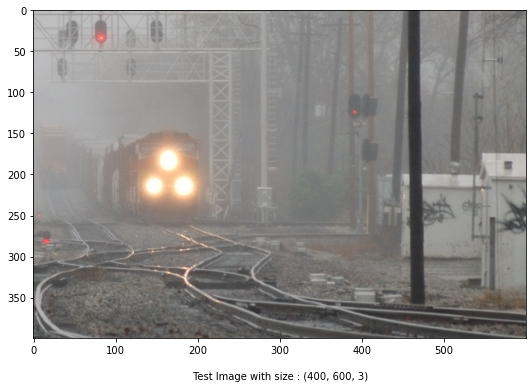

In [4]:
# Displaying the images with their labels

plt.figure(figsize=(30,30))

plt.subplot(3,3,1)
plt.imshow(image1)
plt.xlabel("\n Test Image with size : " + str(image1.shape))

plt.show()

### Performing segmentation of the scene

In [5]:
# A helper map

mp = {}

# Function to create small patches of 

def create_patches(inputImage, num_patches_m, num_patches_n):
    image_height = inputImage.shape[0]
    image_width = inputImage.shape[1]
    
    patch_size_x = image_height // num_patches_m
    patch_size_y = image_width // num_patches_n
    
    # Create a list of patches and store it in the list 'patches'
    
    patches = []
    ctr = 0

    for y in range(0, image_height, patch_size_x):
        for x in range(0, image_width, patch_size_y):
            tiles = inputImage[y: y + patch_size_x, x: x + patch_size_y]
            mp[str(y) + ":" + str(y+patch_size_x) + ";" +  str(x) + ":" + str(x+patch_size_y)] = ctr
            ctr = ctr + 1
            patches.append(tiles)
    
    patches = np.array(patches)
    return patches

In [6]:
# Initialize the input image and calculate the number of patches in x and y dimensions

input_image = image1
input_img = img1
num_patches_m = input_image.shape[0] // 8
num_patches_n = input_image.shape[1] // 8

# Create the patches

patches = create_patches(input_image, num_patches_m, num_patches_n)

In [7]:
# Calculating the value of V

V = np.array([])
for i in range(patches.shape[0]):
    sum_val = np.sum(patches[i] * 1.0)
    mean = sum_val / (patches.shape[1] * patches.shape[2] * patches.shape[3])
    std = np.std(patches[i])
    V = np.append(V, mean - std)

In [8]:
image_height = input_image.shape[0]
image_width = input_image.shape[1]

patch_size_x = image_height // num_patches_m
patch_size_y = image_width // num_patches_n

V_new = np.zeros((image_height, image_width))

for y in range(0, image_height, patch_size_x):
    for x in range(0, image_width, patch_size_y):
        V_new[y: y + patch_size_x, x: x + patch_size_y] = V[mp[str(y) + ":" + str(y+patch_size_x) + ";" +  str(x) + ":" + str(x+patch_size_y)]]


In [9]:
# Sorting the V values and some preprocessing and broadcasting for further steps

l = input_image.shape[0] * input_image.shape[1]

C = np.zeros((input_image.shape[0], input_image.shape[1]))

k = 15

V = V_new
V_flatten = V
V_flatten = V_flatten.flatten()
V_sort = np.sort(V_flatten)
for x in range(V.shape[0]):
    for y in range(V.shape[1]):
        for i in range(k):
            i = i+1
            term1 = max(((i-1)*l)//k, 1)
            term2 = (i*l)//k
            a = V_sort[term1-1]
            b = V_sort[term2-1]
            if (a <= V_new[x, y]) and (V_new[x, y] <= b):
                C[x, y] = i
                break

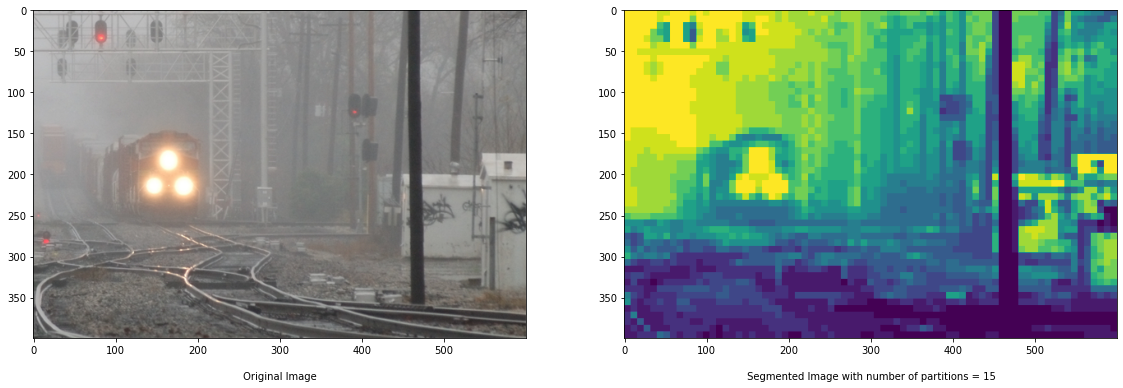

In [10]:
# Plotting the image and its corresponding segmentation map

plt.figure(figsize=(30,30))

plt.subplot(3,3,1)
plt.imshow(input_image)
plt.xlabel("\n Original Image " )

plt.subplot(3,3,2)
plt.imshow(C)
plt.xlabel("\n Segmented Image with number of partitions = " + str(k))

plt.show()

### Performing Erosion and calculate Luminance

In [11]:
# Function to perform erosion and calculate luminance

def erosion_RGB(inputImage, C_in):
    kernel = np.ones((8,8), np.uint8)
    inputImage_R = inputImage[:,:,0]
    inputImage_G = inputImage[:,:,1]
    inputImage_B = inputImage[:,:,2]
    inputImage_R = np.array(inputImage_R)
    inputImage_G = np.array(inputImage_G)
    inputImage_B = np.array(inputImage_B)
    eroded_img_R = cv2.erode(inputImage_R, kernel, iterations=1)
    eroded_img_G = cv2.erode(inputImage_G, kernel, iterations=1)
    eroded_img_B = cv2.erode(inputImage_B, kernel, iterations=1)
    
    plt.figure(figsize=(30,30))

    plt.subplot(3,3,1)
    plt.imshow(eroded_img_R)
    plt.xlabel("\n Eroded image for Red channel")
    
    plt.subplot(3,3,2)
    plt.imshow(eroded_img_G)
    plt.xlabel("\n Eroded image for Green channel")

    plt.subplot(3,3,3)
    plt.imshow(eroded_img_B)
    plt.xlabel("\n Eroded image for Blue channel")
    plt.show()
    
    img_in = np.array(inputImage)
    luminance = []
    luminance_R = []
    luminance_G = []
    luminance_B = []
    for p in range(k):
        temp_R = []
        temp_G = []
        temp_B = []
        for i in range(img_in.shape[0]):
            for j in range(img_in.shape[1]):
                if C_in[i, j] == (p + 1):
                    temp_R.append(eroded_img_R[i][j])
                    temp_G.append(eroded_img_G[i][j])
                    temp_B.append(eroded_img_B[i][j])
        temp_R.sort(reverse=True)
        temp_G.sort(reverse=True)        
        temp_B.sort(reverse=True)      
        top_10_R = temp_R[0:(len(temp_R)//10)]
        top_10_G = temp_G[0:(len(temp_G)//10)]
        top_10_B = temp_B[0:(len(temp_B)//10)]
        avg_R = sum(top_10_R) / len(top_10_R)
        avg_G = sum(top_10_G) / len(top_10_G)
        avg_B = sum(top_10_B) / len(top_10_B)
        luminance_R.append(avg_R)
        luminance_G.append(avg_G)
        luminance_B.append(avg_B)
    return [luminance_R, luminance_G, luminance_B]

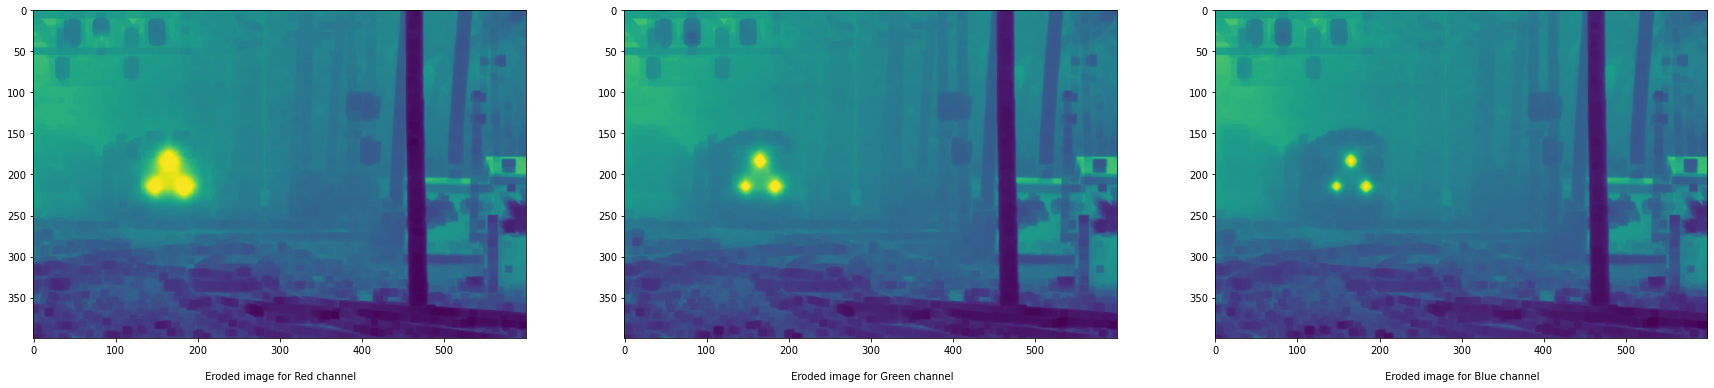

In [12]:
luminance = erosion_RGB(input_image, C)

In [13]:
L = []
for i in range(len(luminance[0])):
    average_luminance = (luminance[0][i] + luminance[1][i] + luminance[2][i]) / 3
    L.append(average_luminance)

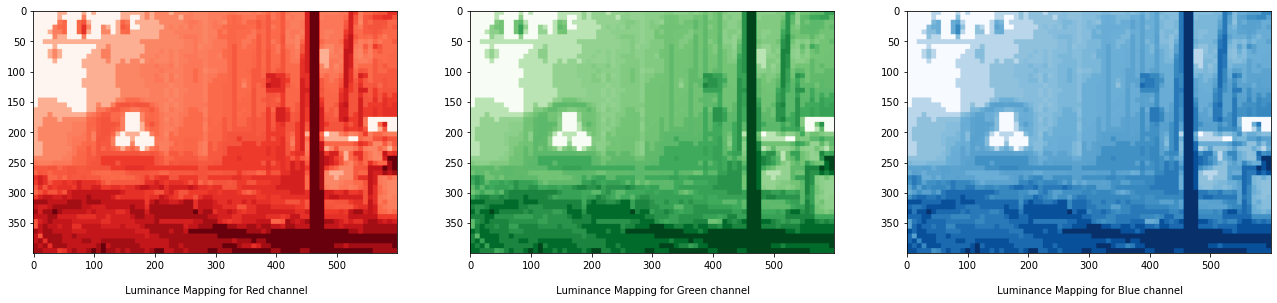

In [14]:
channel_R = np.zeros((input_image.shape[0], input_image.shape[1]))
channel_G = np.zeros((input_image.shape[0], input_image.shape[1]))
channel_B = np.zeros((input_image.shape[0], input_image.shape[1]))

for p in range(k):
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            if C[i, j] == p + 1:
                channel_R[i, j] = L[p]
                channel_G[i, j] = L[p]
                channel_B[i, j] = L[p]

plt.figure(figsize=(30,30))

plt.subplot(1,4,1)
plt.imshow(channel_R, cmap='Reds_r')
plt.xlabel("\n Luminance Mapping for Red channel")

plt.subplot(1,4,2)
plt.imshow(channel_G, cmap='Greens_r')
plt.xlabel("\n Luminance Mapping for Green channel")

plt.subplot(1,4,3)
plt.imshow(channel_B, cmap='Blues_r')
plt.xlabel("\n Luminance Mapping for Blue channel")

plt.show()

In [15]:
def getOptimalT(inputImage, T_i):
    total = 0
    
    f_Rx = cv2.Sobel(inputImage[:,:,0], cv2.CV_16S, 1, 0, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    f_Ry = cv2.Sobel(inputImage[:,:,0], cv2.CV_16S, 0, 1, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    f_R = np.hypot(f_Rx, f_Ry)
    
    f_Gx = cv2.Sobel(inputImage[:,:,1], cv2.CV_64F, 1, 0, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    f_Gy = cv2.Sobel(inputImage[:,:,1], cv2.CV_64F, 0, 1, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    f_G = np.hypot(f_Gx, f_Gy)
    
    f_Bx = cv2.Sobel(inputImage[:,:,2], cv2.CV_64F, 1, 0, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    f_By = cv2.Sobel(inputImage[:,:,2], cv2.CV_64F, 0, 1, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    f_B = np.hypot(f_Bx, f_By)

    for p in range(k):
        for i in range(input_image.shape[0]):
            for j in range(input_image.shape[1]):
                if C[i, j] == (p + 1):
                    a = f_R[i, j] / (luminance[0][p] * T_i)
                    b = f_G[i, j] / (luminance[1][p] * T_i)
                    c = f_B[i, j] / (luminance[2][p] * T_i)
                    total += (a + b + c)
        total*=-1
    return (total)

In [16]:
T_list = []
for i in range(1, 10, 1):
    T_list.append(getOptimalT(input_image, float(i/10)))

In [17]:
T_cap_val = T_list[0]
T_cap_index = -1
for i in range(1, 10, 1):
    if (T_cap_val >= T_list[i-1]):
        T_cap_val = T_list[i-1]
        T_cap_index = i

In [18]:
T_cap = [T_cap_index/10] * k
X_classification_i = []
for p in range(k):
    scene_pixel_count = 0
    V_sum = 0
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            if C[i, j] == (p + 1):
                scene_pixel_count = scene_pixel_count + 1
                V_sum += V[i, j]
    X_classification_i.append(V_sum/scene_pixel_count)

X_classification_i = (X_classification_i - np.min(X_classification_i))/(np.max(X_classification_i)- np.min(X_classification_i))

value1 = X_classification_i - 0.5
value2 = value1**2
value3 = value2 / 0.045
value4 = -value3
value5 = np.exp(value4)
M_magnitude_i = 2 - value5

T_tilde_val = []
for i in range(k):
    T_tilde_val.append(T_cap[i] * M_magnitude_i[i])

scene_trans = np.zeros((input_image.shape[0], input_image.shape[1]))
for i in range(input_image.shape[0]):
    for j in range(input_image.shape[1]):
        for p in range(k):
            if C[i, j] == (p + 1):
                scene_trans[i, j] = T_tilde_val[p]
T_tilde = np.array(scene_trans)

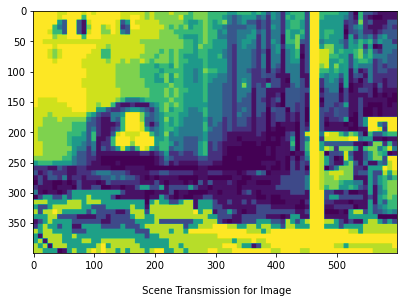

In [19]:
plt.figure(figsize=(30,30))

plt.subplot(1,4,1)
plt.imshow(scene_trans)
plt.xlabel("\n Scene Transmission for Image")

plt.show()

In [20]:
# Creating the W matrix using the given equation

Gray_img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
Gray_imgx = cv2.Sobel(np.array(Gray_img), cv2.CV_16S, 1, 0, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
Gray_imgy = cv2.Sobel(np.array(Gray_img), cv2.CV_16S, 0, 1, ksize = 3, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
Gray_img_grad = np.hypot(Gray_imgx, Gray_imgy)
W_x_y = - Gray_img_grad
W_x_y = np.exp(W_x_y)
W_x_y = 1 - W_x_y

In [21]:
# Set T~ and write functions for breaking condition and edge optimization

T_tilde = scene_trans

In [22]:
def break_condition(T_a, T_b, l, threshold_limit, flag):
    if flag == True:
        T_a = T_a ** k
        T_b = T_b ** k
    T_diff = np.subtract(T_a, T_b)
    T_norm_sqr = np.sum(np.square(T_diff))
    thresh = T_norm_sqr / l
    if(thresh <= threshold_limit):
        return True
    else:
        return False

In [23]:
def edge_optimization_eval(inputImage, T_tilde_local, threshold_limit, flag):
    alpha = 3
    beta = 3
    Itr = 0
    gamma = 4
    r = max(inputImage.shape[0], inputImage.shape[1])//15
    G = np.array(Gray_img)
    
    G_i_filter = -np.ones((r, r))
    T_refine_filter = np.ones((r, r))
    
    G_i_filter[(r//2), (r//2)] = (r*r) - 1
    T_refine_filter[(r//2), (r//2)] = 0
    
    G_minus_G_i = cv2.filter2D(G, -1, G_i_filter)
    
    immutable_term1 = alpha * T_tilde_local
    immutable_term2 = gamma * W_x_y * G_minus_G_i
    immutable_term = immutable_term1 + immutable_term2
    
    T_Refine_Iter = T_tilde_local
    curr_Iter = 1
    while True:
        curr_beta = beta * (curr_Iter - 1)
        T_Refine_Iter_minus_1 = T_Refine_Iter
        
        T_Refine_Iter = cv2.filter2D(T_Refine_Iter, -1, T_refine_filter)
        
        variable_term1 = (W_x_y * (gamma - curr_beta) + curr_beta) * T_Refine_Iter
        variable_term2 = (alpha + ((r*r)-1) * (W_x_y * (gamma - curr_beta) + curr_beta))
        
        T_Refine_Iter = (immutable_term + variable_term1) / variable_term2
        
        curr_Iter = curr_Iter + 1
        
        if (break_condition(T_Refine_Iter, T_Refine_Iter_minus_1, (inputImage.shape[0] * inputImage.shape[1]), threshold_limit, flag)) == True:
            break
    return T_Refine_Iter
convergence_factor = 0.0001


In [24]:
T_final = edge_optimization_eval(input_image, T_tilde, convergence_factor, True)

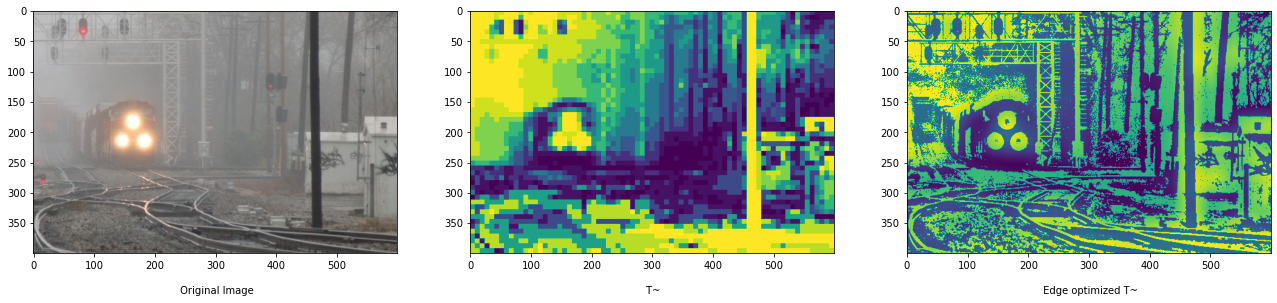

In [25]:
plt.figure(figsize=(30,30))

plt.subplot(1,4,1)
plt.imshow(input_image)
plt.xlabel("\n Original Image")

plt.subplot(1,4,2)
plt.imshow(T_tilde)
plt.xlabel("\n T~")

plt.subplot(1,4,3)
plt.imshow(T_final)
plt.xlabel("\n Edge optimized T~")

plt.show()
convergence_factor = 1

In [26]:
R_final = edge_optimization_eval(input_image, channel_R, convergence_factor, False)

In [27]:
G_final = edge_optimization_eval(input_image, channel_G, convergence_factor, False)

In [28]:
B_final = edge_optimization_eval(input_image, channel_B, convergence_factor, False)

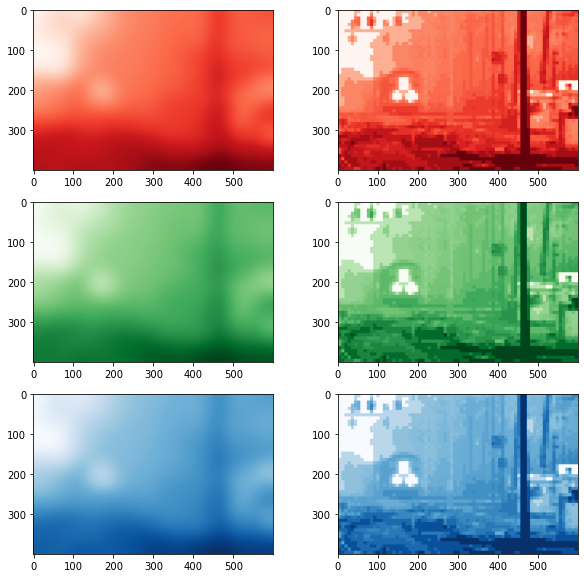

In [29]:
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.imshow(R_final, cmap='Reds_r')
plt.subplot(3,2,2)
plt.imshow(channel_R, cmap='Reds_r')
plt.subplot(3,2,3)
plt.imshow(G_final, cmap='Greens_r')
plt.subplot(3,2,4)
plt.imshow(channel_G, cmap='Greens_r')
plt.subplot(3,2,5)
plt.imshow(B_final, cmap='Blues_r')
plt.subplot(3,2,6)
plt.imshow(channel_B, cmap='Blues_r')

plt.show()

In [30]:
def restoration(inputImage):
    Red_restored = 1 + ((inputImage[:,:,0] - R_final)/(R_final * T_final))
    Green_restored = 1 + ((inputImage[:,:,1] - G_final)/(G_final * T_final))
    Blue_restored = 1 + ((inputImage[:,:,2] - B_final)/(B_final * T_final))

    Red_final = np.minimum(np.maximum(Red_restored, 0), 1)
    Green_final = np.minimum(np.maximum(Green_restored, 0), 1)
    Blue_final = np.minimum(np.maximum(Blue_restored, 0), 1)
    
    output_final_img = np.zeros(inputImage.shape)
    output_final_img[:,:,0] = Red_final
    output_final_img[:,:,1] = Green_final
    output_final_img[:,:,2] = Blue_final
    
    return output_final_img

In [31]:
dehazed_img = restoration(input_image)

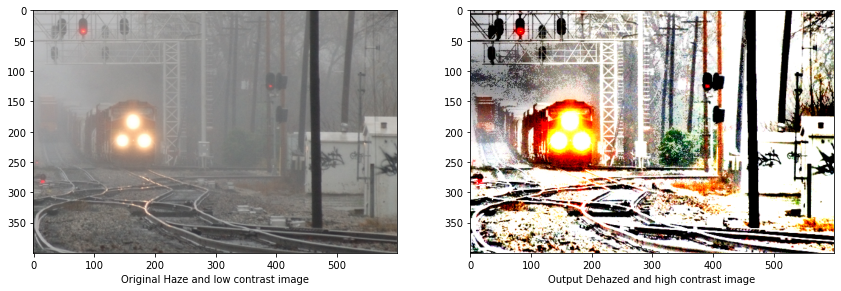

In [32]:
plt.figure(figsize=(30,30))

plt.subplot(3,4,1)
plt.imshow(input_image)
plt.xlabel("Original Haze and low contrast image")
plt.subplot(3,4,2)
plt.imshow(dehazed_img)
plt.xlabel("Output Dehazed and high contrast image")
plt.show()